<a href="https://colab.research.google.com/github/Dhananjay42/cs6910-assn3/blob/main/assn3_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CS6910: Assignment-3
-- Submitted by Dhananjay Balakrishnan, ME19B012

##Setup and Loading the Dataset

In [ ]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.6 MB/s eta 0:00:00


In [ ]:
import csv
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import Levenshtein
import math
import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data_dir = '/content/gdrive/MyDrive/CS6910_A3/aksharantar_sampled/tam/'

In [ ]:
def obtain_data(dir):
  x = []
  y = []

  with open(dir, 'r') as file:
    reader = csv.DictReader(file, fieldnames=['x', 'y'])
  
    for row in reader:
      x.append(row['x'])
      y.append(row['y'])
    
  return x, y

In [ ]:
x_train, y_train = obtain_data(data_dir + 'tam_train.csv')
x_test, y_test = obtain_data(data_dir + 'tam_test.csv')
x_val, y_val = obtain_data(data_dir + 'tam_valid.csv')

In [ ]:
for i in range(0, 2):
  print(x_train[i], y_train[i])

thottacharya தொட்டாச்சார்ய
menmaithaan மென்மைதான்


In [ ]:
start_token = 0
end_token = 1

In [ ]:
#First we define a Language class, which will be used to easily load our dataset.
class Language:
  def __init__(self, name):
    self.name = name
    self.char2index = {}
    self.index2char = {0: "SOS", 1: "EOS", 2: "unknown"} #mapping from index to character
    self.n_chars = 3  # Count SOS, EOS, and unknown. 
    self.max_size = 2 #to find the maximum length of the dataset we're training our model on

  def update_vocab(self, x):
    for word in x:
      if len(word) + 2 > self.max_size:
        self.max_size = len(word) + 2

      for letter in word:
        if letter not in self.char2index.keys():
          self.char2index[letter] = self.n_chars
          self.index2char[self.n_chars] = letter
          self.n_chars = self.n_chars + 1
  
  def get_index(self, character):
    if character in self.char2index.keys():
      return self.char2index[character]
    else:
      return 2
  
  def get_character(self, index):
    if index == 2:
      return '$'
    else:
      return self.index2char[index]

In [ ]:
english = Language('eng')
tamil = Language('tam')

In [ ]:
english.update_vocab(x_train)
tamil.update_vocab(y_train)

In [ ]:
def encoded_word(language, word):
  coded = [language.get_index(letter) for letter in word]
  coded.append(end_token)
  return coded

def get_pairs(lang1, lang2, inputs, targets):
  return [(torch.tensor(encoded_word(lang1, x), dtype=torch.long, device=device).view(-1, 1), torch.tensor(encoded_word(lang2, y), dtype=torch.long, device=device).view(-1, 1)) 
  for (x,y) in zip(inputs,targets)]

def decoded_word(language, encoded_word):
  if encoded_word[-1] == end_token:
    encoded_word = encoded_word[:-1]

  characters = [language.get_character(num) for num in encoded_word]
  decoded = ''.join(characters)
  return decoded

In [ ]:
train_data = get_pairs(english, tamil, x_train, y_train)
test_data = get_pairs(english, tamil, x_test, y_test)
val_data = get_pairs(english, tamil, x_val, y_val)

#RNN without Attention

In [ ]:
class Encoder(nn.Module):
  def __init__(self, inp_vocab_size, embedding_size, n_layers, hl_size, dropout, cell_type, bidirectional):
    super(Encoder, self).__init__()
    self.vocab_size = inp_vocab_size
    self.embedding_size = embedding_size
    self.n_layers = n_layers
    self.hl_size = hl_size
    self.bidirectional = bidirectional
    self.cell_type = cell_type
    self.dropout = dropout

    if cell_type == 'RNN':
      self.cell = nn.RNN(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'GRU':
      self.cell = nn.GRU(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'LSTM':
      self.cell = nn.LSTM(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    else:
      print('Wrong Cell Type.')
      exit()
    self.embedding_layer = nn.Embedding(self.vocab_size, self.embedding_size).to(device)
  
  def forward(self, input, hidden, c = 0):
    embedded = self.embedding_layer(input).view(1, 1, -1)
    if self.cell_type != 'LSTM':
      output, hidden = self.cell(embedded, hidden)
      
      return output, hidden

    else:
      output, (hidden, c) = self.cell(embedded, (hidden, c))

      return output, hidden, c
  
  def init_hidden(self):
    if self.bidirectional:
      return torch.zeros(self.n_layers*2, 1, self.hl_size, device = device)
    else:
      return torch.zeros(self.n_layers, 1, self.hl_size, device = device)

In [ ]:
class DecoderVanilla(nn.Module):
  def __init__(self, out_vocab_size, embedding_size, n_layers, hl_size, dropout, cell_type, bidirectional):
    super(DecoderVanilla, self).__init__()
    self.vocab_size = out_vocab_size
    self.embedding_size = embedding_size
    self.n_layers = n_layers
    self.hl_size = hl_size
    self.softmax = nn.LogSoftmax(dim=1)
    self.cell_type = cell_type
    self.bidirectional = bidirectional
    self.dropout = dropout

    if self.bidirectional:
      self.linear = nn.Linear(2*self.hl_size, self.vocab_size).to(device)
    else:
      self.linear = nn.Linear(self.hl_size, self.vocab_size).to(device)

    if cell_type == 'RNN':
      self.cell = nn.RNN(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'GRU':
      self.cell = nn.GRU(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'LSTM':
      self.cell = nn.LSTM(self.embedding_size, self.hl_size, num_layers = self.n_layers, dropout = self.dropout, bidirectional = self.bidirectional).to(device)
    else:
      print('Wrong Cell Type.')
      exit()
    
    self.embedding_layer = nn.Embedding(self.vocab_size, self.embedding_size).to(device)
  
  def forward(self, input, hidden, c = 0):
    embedded = self.embedding_layer(input).view(1, 1, -1)
    output = F.relu(embedded)

    if self.cell_type != 'LSTM':
      output, hidden = self.cell(output, hidden)
      output = self.linear(output[0])
      output = self.softmax(output)
      return output, hidden
    else:
      output, (hidden, c) = self.cell(output, (hidden, c))
      output = self.linear(output[0])
      output = self.softmax(output)
      return output, hidden, c

In [ ]:
class seq2seq_vanilla():
  def __init__(self, inp_language, out_language, embedding_size, n_layers, hl_size, dropout = 0.2, cell_type = 'LSTM', lr = 0.01, teacher_forcing_ratio = 0.5,bidirectional_flag = False):
    self.encoder = Encoder(inp_language.n_chars, embedding_size, n_layers, hl_size, dropout, cell_type, bidirectional = bidirectional_flag)
    self.decoder = DecoderVanilla(out_language.n_chars, embedding_size, n_layers, hl_size, dropout, cell_type, bidirectional = bidirectional_flag)
    self.lr = lr
    self.teacher_forcing = teacher_forcing_ratio
    self.max_length = out_language.max_size
    self.cell_type = cell_type

    self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=self.lr)
    self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr = self.lr)

    self.loss_fn = nn.NLLLoss()

  def train_step(self, input, target):
    encoder_hidden = self.encoder.init_hidden()
    encoder_c = self.encoder.init_hidden()

    self.encoder_optimizer.zero_grad()
    self.decoder_optimizer.zero_grad()

    input_length = input.size(0)
    target_length = target.size(0)

    loss = 0

    for i in range(0, input_length):
      if self.cell_type != 'LSTM':
        encoder_output, encoder_hidden = self.encoder.forward(input[i], encoder_hidden)
      else:
        encoder_output, encoder_hidden, encoder_c = self.encoder.forward(input[i], encoder_hidden, encoder_c)
    
    decoder_input = torch.tensor([[start_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_c = encoder_c

    num = random.random()

    if num < self.teacher_forcing:
      #here, we use teacher forcing. 
      for j in range(0, target_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden = self.decoder.forward(decoder_input, decoder_hidden)
        else:
          decoder_output, decoder_hidden, decoder_c = self.decoder.forward(decoder_input, decoder_hidden, decoder_c)

        loss = loss + self.loss_fn(decoder_output, target[j])
        decoder_input = target[j]#.unsqueeze(0)

    else:
      #here, there is no teacher forcing. the predictions themselves are used. 
      for j in range(0, target_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden = self.decoder.forward(decoder_input, decoder_hidden)
        else:
          decoder_output, decoder_hidden, decoder_c = self.decoder.forward(decoder_input, decoder_hidden, decoder_c)

        loss = loss + self.loss_fn(decoder_output, target[j])
        value, index = decoder_output.topk(1)
        decoder_input = index.squeeze().detach()
        if decoder_input.item() == end_token:
          break
  
    loss.backward()
    self.encoder_optimizer.step()
    self.decoder_optimizer.step()

    return loss.item()/target_length
  
  def predict(self, input, target):
    #here, we use the model to inference. 
    with torch.no_grad():
      encoder_hidden = self.encoder.init_hidden()
      encoder_c = self.encoder.init_hidden()

      input_length = input.size(0)
      for i in range(0, input_length):
        if self.cell_type != 'LSTM':
          encoder_output, encoder_hidden = self.encoder.forward(input[i], encoder_hidden)
        else:
          encoder_output, encoder_hidden, encoder_c = self.encoder.forward(input[i], encoder_hidden, encoder_c)

      decoder_input = torch.tensor([[start_token]], device=device)
      decoder_hidden = encoder_hidden
      decoder_c = encoder_c

      outputs = []
      for i in range(0, self.max_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden = self.decoder.forward(decoder_input, decoder_hidden)
        else:
          decoder_output, decoder_hidden, decoder_c = self.decoder.forward(decoder_input, decoder_hidden, decoder_c)

        value, index = decoder_output.data.topk(1)
        decoder_input = index.squeeze().detach()
        outputs.append(decoder_input.item())
        if decoder_input.item() == end_token:
          break

      return outputs
  
  def predict_beam(self, input, beam_size):
    #this is used to predict b outputs, where b is the beam size. 
    with torch.no_grad():
      encoder_hidden = self.encoder.init_hidden()
      encoder_c = self.encoder.init_hidden()

      input_length = input.size(0)
      for i in range(0, input_length):
        if self.cell_type != 'LSTM':
          encoder_output, encoder_hidden = self.encoder.forward(input[i], encoder_hidden)
        else:
          encoder_output, encoder_hidden, encoder_c = self.encoder.forward(input[i], encoder_hidden, encoder_c)

      decoder_input = torch.tensor([[start_token]], device=device)
      decoder_hidden = encoder_hidden
      decoder_c = encoder_c

      possible_outputs = [] #a list of lists containing the top "beam_size" set of the best possible outputs at an instance
      next_inputs = [] #list containing the tensors that are to be fed as the next input
      decoder_hiddens = [] #list containing the hidden values corresponding to the given outputs
      decoder_cs = [] #list containing the cell states (in case we use an LSTM)

      if self.cell_type != 'LSTM':
        decoder_output, decoder_hidden = self.decoder.forward(decoder_input, decoder_hidden)
      else:
        decoder_output, decoder_hidden, decoder_c = self.decoder.forward(decoder_input, decoder_hidden, decoder_c)
        
      values, indices = decoder_output.data.topk(beam_size) #we unpack the top b values and their corresponding indices
      values = torch.exp(values) #we would like to deal with a probability instead of a log-probability, so we do e^val

      for j in range(0, beam_size):
        #we do on iteration and populate the above lists. we will then use these lists to iteratively get our best b guesses. 
        value = values[0, j]
        index = indices[0, j]
        possible_outputs.append([index.item()])
        next_inputs.append(index.squeeze().detach())
        decoder_hiddens.append(decoder_hidden)
        if self.cell_type == 'LSTM':
          decoder_cs.append(decoder_c)
                    
      for k in range(1, self.max_length):
        #now, we make predictions for the other timesteps
        temp_probabilities = np.zeros([beam_size, beam_size])
        temp_indices = []
        temp_hiddens = []
        temp_cs = []

        for i in range(0, beam_size):
          #we first iterate through all possible current inputs and their corresponding hidden states
          curr_input = next_inputs[i]
          hidden = decoder_hiddens[i]
          if self.cell_type == 'LSTM':
            c = decoder_cs[i]
          
          if self.cell_type != 'LSTM':
            decoder_output, decoder_hidden = self.decoder.forward(curr_input, hidden)
          else:
            decoder_output, decoder_hidden, decoder_c = self.decoder.forward(curr_input, hidden, c)
            temp_cs.append(decoder_c)
            
          #following this, we get the top b values for each of these inputs
          temp_hiddens.append(decoder_hidden)
          values, indices = decoder_output.data.topk(beam_size)
          values = torch.exp(values)

          temp_temp_indices = []
          for j in range(0, beam_size):
            #we now iterate through these b predictions correponding to a given input, and construct a probability table
            #this probability table gives the conditional probability of the output, given the input sequence. 
            value = values[0, j]
            index = indices[0, j]
            temp_probabilities[i][j] = value.item()
            temp_temp_indices.append(index.squeeze().detach())

            if curr_input.item() == end_token:
              temp_temp_indices.append(torch.tensor([[end_token]], device= device))
          
          temp_indices.append(temp_temp_indices)
        
        #we then choose the best b probabilities from these
        mat = np.array(temp_probabilities)
        idx = np.argpartition(mat, mat.size - beam_size, axis=None)[-beam_size:]
        results = np.column_stack(np.unravel_index(idx, mat.shape)) 

        updated_outputs = []

        decoder_hiddens = []
        decoder_cs = []
        next_inputs = []

        for i, result in enumerate(results):
          #we finally iterate through these best sequences and update our next_inputs, hiddens, and our possible_outputs. 
          x = result[0]
          y = result[1]
          next_inputs.append(temp_indices[x][y])
          decoder_hiddens.append(temp_hiddens[x])
          if self.cell_type == 'LSTM':
            decoder_cs.append(temp_cs[x])

          arr = copy.deepcopy(possible_outputs[x])
          if arr[-1] == end_token:
            pass
          else:
            arr.append(temp_indices[x][y].item())

          updated_outputs.append(arr)
        
        possible_outputs = copy.deepcopy(updated_outputs)

      #we finally return a set of predictions instead of one prediction.             
      return possible_outputs

  def evaluate_beam(self, data, beam_size, print_flag = True):
    #same as the evaluate fn, except we check for the multiple outputs generated 
    #by the beam based predict method, and choose the best one to get a good performance. 
    correct = 0
    character_wise = 0
    count = 0
    total_distance = 0

    for pair in data:
      input = pair[0]
      target = pair[1]
      predictions = self.predict_beam(input, beam_size)
      target = target.tolist()
      target = [t[0] for t in target]
      tar_word = decoded_word(tamil,target)

      mini = 2

      for pred in predictions:
        pred_word = decoded_word(tamil,pred)
        if pred_word == tar_word:
          correct = correct + 1
        
        dist = min((Levenshtein.distance(pred_word, tar_word)/max(len(tar_word),len(pred_word))), 1)
        if dist < mini:
          mini = dist
      
      if print_flag:
        if count%500 == 0:
          print([decoded_word(tamil, pred) for pred in predictions], tar_word)
        count = count + 1
      
      total_distance = total_distance + mini
    
    avg_distance = total_distance/len(data)
    char_acc = 1 - avg_distance
    acc = correct/len(data)
    return acc, char_acc


  def evaluate(self, data, print_flag = True):
    correct = 0
    character_wise = 0
    count = 0
    total_distance = 0

    for pair in data:
      input = pair[0]
      target = pair[1]
      pred = self.predict(input, target)
      target = target.tolist()
      target = [t[0] for t in target]

      if print_flag:
        if count%500 == 0:
          print(decoded_word(tamil,pred), decoded_word(tamil,target))
        count = count + 1

      pred_word = decoded_word(tamil,pred)
      tar_word = decoded_word(tamil,target)
      
      if pred_word == tar_word:
        correct = correct + 1
      
      total_distance = total_distance + min((Levenshtein.distance(pred_word, tar_word)/max(len(tar_word),len(pred_word))), 1)
    
    avg_distance = total_distance/len(data)
    char_acc = 1 - avg_distance
    acc = correct/len(data)

    return acc, char_acc

In [ ]:
model = seq2seq_vanilla(inp_language = english, out_language = tamil, embedding_size = 64, n_layers = 2, hl_size = 128)

In [ ]:
n_iters = 75000

In [ ]:
print(len(val_data))

4096


In [ ]:
training_pairs = [random.choice(train_data) for i in range(0, n_iters)]

In [ ]:
# train_loss = 0
# for i in range(0, n_iters):
#   training_pair = training_pairs[i]
#   x = training_pair[0]
#   y = training_pair[1]
#   loss = model.train_step(x, y)
#   train_loss = train_loss + loss

#   if (i+1)%5000 == 0:
#     print('------------------------------------------------')
#     print('train loss is:', train_loss/5000)
#     test_acc, char_acc = model.evaluate(val_data)
#     print(f'test accuracy is {test_acc} and character-wise accuracy is {char_acc}')
#     train_loss = 0

#RNN with Attention

In [ ]:
class DecoderAttn(nn.Module):
  def __init__(self, out_vocab_size, max_length, embedding_size, hl_size, dropout, cell_type, bidirectional):
    super(DecoderAttn, self).__init__()
    self.vocab_size = out_vocab_size
    self.embedding_size = embedding_size
    self.hl_size = hl_size
    self.softmax = nn.LogSoftmax(dim=1)
    self.cell_type = cell_type
    self.bidirectional = bidirectional
    self.dropout = dropout
    self.max_length = max_length

    self.dropout_layer = nn.Dropout(self.dropout).to(device)


    if self.bidirectional:
      self.linear = nn.Linear(2*self.hl_size, self.vocab_size).to(device)
      self.attention = nn.Linear(2*self.hl_size + self.embedding_size, self.max_length).to(device)
      self.attn_combine = nn.Linear(2*self.hl_size + self.embedding_size, self.embedding_size).to(device)

    else:
      self.linear = nn.Linear(self.hl_size, self.vocab_size).to(device)
      self.attention = nn.Linear(self.hl_size + self.embedding_size, self.max_length).to(device)
      self.attn_combine = nn.Linear(self.hl_size + self.embedding_size, self.embedding_size).to(device)


    if cell_type == 'RNN':
      self.cell = nn.RNN(self.embedding_size, self.hl_size, num_layers = 1, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'GRU':
      self.cell = nn.GRU(self.embedding_size, self.hl_size, num_layers = 1, bidirectional = self.bidirectional).to(device)
    elif cell_type == 'LSTM':
      self.cell = nn.LSTM(self.embedding_size, self.hl_size, num_layers = 1, bidirectional = self.bidirectional).to(device)
    else:
      print('Wrong Cell Type.')
      exit()
    
    self.embedding_layer = nn.Embedding(self.vocab_size, self.embedding_size).to(device)
  
  def forward(self, input, hidden, encoder_outputs, c = 0):
    embedded = self.embedding_layer(input).view(1, 1, -1)
    embedded = self.dropout_layer(embedded)

    if self.bidirectional:
      concatenated = torch.cat((embedded[0], hidden[0], hidden[1]), 1)
    else:
      concatenated = torch.cat((embedded[0], hidden[0]), 1)
    #print(embedded.shape, hidden.shape, concatenated.shape)
    #print(embedded.shape, hidden.shape, concatenated.shape)

    attn_weights = F.softmax(self.attention(concatenated), dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    if self.cell_type != 'LSTM':
      output, hidden = self.cell(output, hidden)
      output = self.linear(output[0])
      output = self.softmax(output)
      return output, hidden, attn_weights
    else:
      output, (hidden, c) = self.cell(output, (hidden, c))
      output = self.linear(output[0])
      output = self.softmax(output)
      return output, hidden, c, attn_weights

In [ ]:
class seq2seq_attn():
  def __init__(self, inp_language, out_language, embedding_size, hl_size, dropout = 0.2, cell_type = 'LSTM', lr = 0.005, teacher_forcing_ratio = 0.5,bidirectional_flag = True):
    self.max_length = max(out_language.max_size,  inp_language.max_size)
    self.encoder = Encoder(inp_language.n_chars, embedding_size, 1, hl_size, dropout, cell_type, bidirectional = bidirectional_flag)
    self.decoder = DecoderAttn(out_language.n_chars, self.max_length, embedding_size, hl_size, dropout, cell_type, bidirectional = bidirectional_flag)
    self.lr = lr
    self.teacher_forcing = teacher_forcing_ratio
    self.cell_type = cell_type
    self.bidir = bidirectional_flag

    self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=self.lr)
    self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr = self.lr)

    self.loss_fn = nn.NLLLoss()
    #decay^30000 = 0.2
    self.decay_rate = 2**(math.log2(0.2)/30000)
    #self.decay = lambda epoch: self.decay_rate
    self.encoder_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(self.encoder_optimizer, lr_lambda=self.decay)
    self.decoder_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(self.decoder_optimizer, lr_lambda=self.decay)
  
  def decay(self, epoch):
    return self.decay_rate

  def train_step(self, input, target):
    encoder_hidden = self.encoder.init_hidden()
    encoder_c = self.encoder.init_hidden()

    self.encoder_optimizer.zero_grad()
    self.decoder_optimizer.zero_grad()

    input_length = input.size(0)
    target_length = target.size(0)

    loss = 0

    if self.bidir == True:
      encoder_outputs = torch.zeros(self.max_length, 2*self.encoder.hl_size, device=device)
    else:
      encoder_outputs = torch.zeros(self.max_length, self.encoder.hl_size, device=device)

    for i in range(0, input_length):
      if self.cell_type != 'LSTM':
        encoder_output, encoder_hidden = self.encoder.forward(input[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]
      else:
        encoder_output, encoder_hidden, encoder_c = self.encoder.forward(input[i], encoder_hidden, encoder_c)
        encoder_outputs[i] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[start_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_c = encoder_c

    num = random.random()

    if num < self.teacher_forcing:
      #here, we use teacher forcing. 
      for j in range(0, target_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_hidden, decoder_c, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs, decoder_c)

        loss = loss + self.loss_fn(decoder_output, target[j])
        decoder_input = target[j]#.unsqueeze(0)

    else:
      #here, there is no teacher forcing. the predictions themselves are used. 
      for j in range(0, target_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_hidden, decoder_c, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs, decoder_c)

        loss = loss + self.loss_fn(decoder_output, target[j])
        value, index = decoder_output.topk(1)
        decoder_input = index.squeeze().detach()
        if decoder_input.item() == end_token:
          break
      
            
    loss.backward()
    self.encoder_optimizer.step()
    self.decoder_optimizer.step()

    self.encoder_scheduler.step()
    self.decoder_scheduler.step()

    return loss.item()/target_length
  
  def predict(self, input, target):
    with torch.no_grad():
      encoder_hidden = self.encoder.init_hidden()
      encoder_c = self.encoder.init_hidden()

      if self.bidir == True:
        encoder_outputs = torch.zeros(self.max_length, 2*self.encoder.hl_size, device=device)
      else:
        encoder_outputs = torch.zeros(self.max_length, self.encoder.hl_size, device=device)

      input_length = input.size(0)
      for i in range(0, min(input_length, self.max_length)):
        if self.cell_type != 'LSTM':
          encoder_output, encoder_hidden = self.encoder.forward(input[i], encoder_hidden)
          encoder_outputs[i] = encoder_output[0, 0]
        else:
          encoder_output, encoder_hidden, encoder_c = self.encoder.forward(input[i], encoder_hidden, encoder_c)
          encoder_outputs[i] = encoder_output[0, 0]

      decoder_input = torch.tensor([[start_token]], device=device)
      decoder_hidden = encoder_hidden
      decoder_c = encoder_c

      outputs = []
      for i in range(0, self.max_length):
        if self.cell_type != 'LSTM':
          decoder_output, decoder_hidden, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_hidden, decoder_c, decoder_attention = self.decoder.forward(decoder_input, decoder_hidden, encoder_outputs, decoder_c)

        value, index = decoder_output.data.topk(1)
        decoder_input = index.squeeze().detach()
        outputs.append(decoder_input.item())
        if decoder_input.item() == end_token:
          break

      return outputs


  def evaluate(self, data):
    correct = 0
    character_wise = 0
    count = 0
    total_distance = 0

    for pair in data:
      input = pair[0]
      target = pair[1]
      pred = self.predict(input, target)
      target = target.tolist()
      target = [t[0] for t in target]

      # if count%500 == 0:
      #   print(decoded_word(tamil,pred), decoded_word(tamil,target))
      # count = count + 1

      pred_word = decoded_word(tamil,pred)
      tar_word = decoded_word(tamil,target)
      
      if pred_word == tar_word:
        correct = correct + 1
      
      total_distance = total_distance + min((Levenshtein.distance(pred_word, tar_word)/max(len(tar_word),len(pred_word))), 1)
    
    avg_distance = total_distance/len(data)
    char_acc = 1 - avg_distance
    acc = correct/len(data)


    return acc, char_acc

In [ ]:
model = seq2seq_attn(inp_language = english, out_language = tamil, embedding_size = 128, hl_size = 128)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# train_loss = 0
# for i in range(0, n_iters):
#   training_pair = training_pairs[i]
#   x = training_pair[0]
#   y = training_pair[1]
#   loss = model.train_step(x, y)
#   train_loss = train_loss + loss

#   if (i+1)%5000 == 0:
#     print('------------------------------------------------')
#     print('train loss is:', train_loss/5000)
#     test_acc, char_acc = model.evaluate(val_data)
#     print(f'test accuracy is {test_acc} and character-wise accuracy is {char_acc}')
#     train_loss = 0

#WandB Setup




In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=ac302d639c494f3acefec8c109b11452c4d8e965d2a85034350f997f5dcc347b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb

In [ ]:
!wandb login
#63a3fc8a45a3ca461290e711c17782295dfe1975

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 41
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
entity_name = "clroymustang"
project_name = "cs6910-assignment-3"

#Vanilla Hyperparameter Sweep

In [ ]:
n_iters = 75000

In [ ]:
training_pairs = [random.choice(train_data) for i in range(0, n_iters)]

In [ ]:
def sweep():
  defaults = {
      'embedding_size': 32,
      'n_layers': 1,
      'hl_size': 32,
      'bidir': False,
      'dropout': 0,
      'cell_type': 'GRU'
  }
  wandb.init(config = defaults)
  config = wandb.config

  vanilla_model = seq2seq_vanilla(english, tamil, embedding_size = config.embedding_size, n_layers = config.n_layers, hl_size = config.hl_size, dropout = config.dropout, \
                          cell_type = config.cell_type, lr = 0.01, teacher_forcing_ratio = 0.5, bidirectional_flag = config.bidir)
  
  train_loss = 0
  for i in range(0, n_iters):
    training_pair = training_pairs[i]
    x = training_pair[0]
    y = training_pair[1]
    loss = vanilla_model.train_step(x, y)
    train_loss = train_loss + loss

    if (i+1)%5000 == 0:
      test_acc, char_acc = vanilla_model.evaluate(val_data)
      train_loss = train_loss/5000
      log_dict = {"train_loss":train_loss, "test_accuracy":test_acc, "test_similarity":char_acc}
      wandb.log(log_dict)
      train_loss = 0
  
  sweep_name = str(config.cell_type) + "_emb" + str(config.embedding_size) + "_hl" + str(config.hl_size) + "_nl" + str(config.n_layers) + "_d" + \
  str(config.dropout) + "_bidir" + str(config.bidir)
  wandb.run.name = sweep_name

  wandb.run.save()
  wandb.run.finish()


In [ ]:
hyperparameters = {
      "embedding_size": {
          'values': [32, 64, 128]
      },
      "n_layers": {
          'values' : [1, 2, 3]
      },
      "hl_size": {
          'values' : [32, 64, 128]
      },
      "bidir": {
          'values': [True, False]
      },
      "dropout":{
        'values': [0, 0.2, 0.3]
      },
      "cell_type": {
          'values' : ['RNN', 'GRU', 'LSTM']
      }
  }

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'vanilla_sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'test_similarity'
        },
    'parameters': hyperparameters
}

In [ ]:
#sweep_id = wandb.sweep(sweep_configuration, entity=entity_name, project=project_name)
sweep_id = 'td3auwvp'

In [ ]:
#wandb.agent(sweep_id, sweep, project = project_name)

tinkering

#Attention Hyperparameter Mini-Sweep



In [ ]:
hyperparameters = {
      "embedding_size": {
          'values': [128]
      },
      "n_layers": {
          'values' : [1]
      },
      "hl_size": {
          'values' : [128]
      },
      "bidir": {
          'values': [True, False]
      },
      "dropout":{
        'values': [0.2]
      },
      "cell_type": {
          'values' : ['GRU', 'LSTM']
      },
      "attention": {
          'values' : [True, False]
      }
  }

In [ ]:
def sweep():
  defaults = {
      'embedding_size': 128,
      'n_layers': 1,
      'hl_size': 128,
      'bidir': False,
      'dropout': 0.2,
      'cell_type': 'GRU',
      'attention': False
  }
  wandb.init(config = defaults)
  config = wandb.config

  if config.attention:
    model = seq2seq_attn(english, tamil, embedding_size = config.embedding_size, hl_size = config.hl_size, dropout = config.dropout, cell_type = config.cell_type, \
                         lr = 0.005, teacher_forcing_ratio = 0.5, bidirectional_flag = config.bidir)
  else:
    model = seq2seq_vanilla(english, tamil, embedding_size = config.embedding_size, n_layers = config.n_layers, hl_size = config.hl_size, dropout = config.dropout, \
                          cell_type = config.cell_type, lr = 0.01, teacher_forcing_ratio = 0.5, bidirectional_flag = config.bidir)
  
  train_loss = 0
  for i in range(0, n_iters):
    training_pair = training_pairs[i]
    x = training_pair[0]
    y = training_pair[1]
    loss = model.train_step(x, y)
    train_loss = train_loss + loss

    if (i+1)%5000 == 0:
      test_acc, char_acc = model.evaluate(val_data)
      train_loss = train_loss/5000
      log_dict = {"train_loss":train_loss, "test_accuracy":test_acc, "test_similarity":char_acc}
      wandb.log(log_dict)
      train_loss = 0
  
  sweep_name = str(config.cell_type) + "_emb" + str(config.embedding_size) + "_hl" + str(config.hl_size) + "_d" + \
  str(config.dropout) + "_bidir" + str(config.bidir) + "_attn" + str(config.attention)

  wandb.run.name = sweep_name

  wandb.run.save()
  wandb.run.finish()

In [ ]:
sweep_configuration = {
    'method': 'grid',
    'name': 'attention_sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'test_similarity'
        },
    'parameters': hyperparameters
}

In [ ]:
#sweep_id = wandb.sweep(sweep_configuration, entity=entity_name, project=project_name)
sweep_id = '6l900368'

In [ ]:
#wandb.agent(sweep_id, sweep, project = project_name)

#Best Vanilla Model

In [ ]:
best_params = {
    'cell_type':'LSTM', 'dropout':0, 'embedding_size':128, 'hl_size':128, 'n_layers':3, 'bidirectional_flag':False
}

In [ ]:
model = seq2seq_vanilla(inp_language = english, out_language = tamil, **best_params)

In [ ]:
n_iters = 75000

In [ ]:
training_pairs = [random.choice(train_data) for i in range(0, n_iters)]

In [ ]:
train_loss = 0
for i in range(0, n_iters):
  training_pair = training_pairs[i]
  x = training_pair[0]
  y = training_pair[1]
  loss = model.train_step(x, y)
  train_loss = train_loss + loss

  if (i+1)%5000 == 0:
    print('------------------------------------------------')
    print('train loss is:', train_loss/5000)
    test_acc, char_acc = model.evaluate(val_data)
    print(f'test accuracy is {test_acc} and character-wise accuracy is {char_acc}')
    train_loss = 0

In [ ]:
with open('best_vanilla_model.pkl', 'wb') as file:
  pickle.dump(model, file)
  print('Object successfully saved.')

In [ ]:
pickled_model = pickle.load(open('best_vanilla_model.pkl', 'rb'))

#Beam Search

In [ ]:
#we will now perform beam search for various values of B and compare the results
# for b in range(2, 6):
#   test_acc, char_acc = pickled_model.evaluate_beam(val_data, beam_size = b, print_flag = False)
#   print(f'With beam size = {b}, we get a test accuracy of {test_acc} and a character-wise similarity as {char_acc}.')

Text(0, 0.5, 'Validation Accuracy')

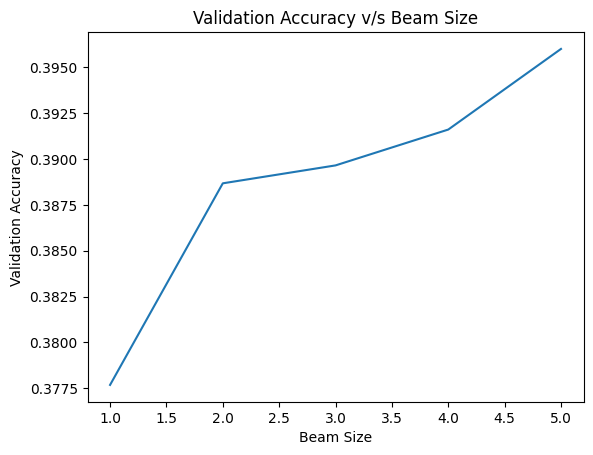

In [ ]:
b = [1, 2, 3, 4, 5]
test_acc = [0.377685546875, 0.388671875, 0.3896484375, 0.3916015625, 0.39599609375]
test_sim = [0.8217747135037511, 0.8271914291907654, 0.8307840395134558, 0.8324873635588594, 0.8336391599211628]

plt.plot(b, test_acc)
plt.title('Validation Accuracy v/s Beam Size')
plt.xlabel('Beam Size')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'Validation Similarity')

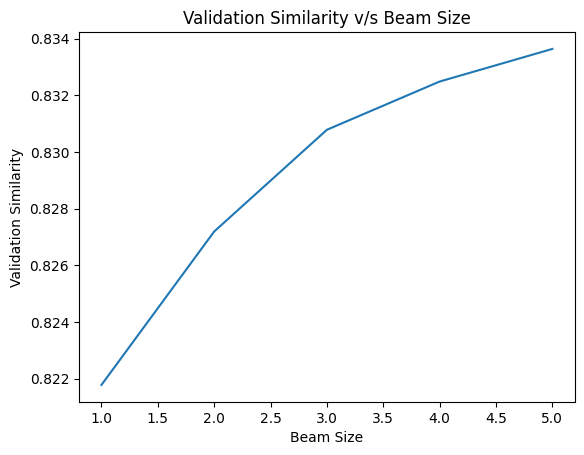

In [ ]:
plt.plot(b, test_sim)
plt.title('Validation Similarity v/s Beam Size')
plt.xlabel('Beam Size')
plt.ylabel('Validation Similarity')

#Best Attention Model

In [ ]:
best_params = {
    'cell_type':'GRU', 'dropout':0.2, 'embedding_size':128, 'hl_size':128, 'bidirectional_flag':True
}

In [ ]:
model = seq2seq_attn(inp_language = english, out_language = tamil, **best_params)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
train_loss = 0
for i in range(0, n_iters):
  training_pair = training_pairs[i]
  x = training_pair[0]
  y = training_pair[1]
  loss = model.train_step(x, y)
  train_loss = train_loss + loss

  if (i+1)%5000 == 0:
    print('------------------------------------------------')
    print('train loss is:', train_loss/5000)
    test_acc, char_acc = model.evaluate(val_data)
    print(f'test accuracy is {test_acc} and character-wise accuracy is {char_acc}')
    train_loss = 0

------------------------------------------------
train loss is: 1.903665394523643
test accuracy is 0.043701171875 and character-wise accuracy is 0.6178185361722799
------------------------------------------------
train loss is: 1.119872172133049
test accuracy is 0.1669921875 and character-wise accuracy is 0.7318605761966062
------------------------------------------------
train loss is: 0.8010369807866555
test accuracy is 0.299072265625 and character-wise accuracy is 0.7975959612835202
------------------------------------------------
train loss is: 0.5968623266388231
test accuracy is 0.364013671875 and character-wise accuracy is 0.8230459448770827
------------------------------------------------
train loss is: 0.4952203252231501
test accuracy is 0.3828125 and character-wise accuracy is 0.8301898847232598
------------------------------------------------
train loss is: 0.42420165220586803
test accuracy is 0.414794921875 and character-wise accuracy is 0.8393633873834718
------------------

In [ ]:
with open('best_attn_model.pkl', 'wb') as file:
  pickle.dump(model, file)
  print('Object successfully saved.')

Object successfully saved.


#Evaluation of Vanilla Model on Test-Dataset

In [ ]:
vanilla_model = pickle.load(open('/content/gdrive/MyDrive/CS6910_A3/best_models/best_vanilla_model.pkl', 'rb'))

In [ ]:
test_acc, test_sim = vanilla_model.evaluate(test_data, False)
print(f'The model has test accuracy: {test_acc} and test similarity:{test_sim}.')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


The model has test accuracy: 0.320556640625 and test similarity:0.7873471098288715.


In [ ]:
vanilla_values = []
for test_pair in test_data:
  input = test_pair[0]
  target = test_pair[1]
  pred = vanilla_model.predict(input, target)

  target = target.tolist()
  target = [t[0] for t in target]
  input = input.tolist()
  input = [i[0] for i in input]

  tar_word = decoded_word(tamil, target)
  inp_word = decoded_word(english, input)
  pred_word = decoded_word(tamil, pred)

  vanilla_values.append([inp_word, tar_word, pred_word])

In [ ]:
import csv
header = ['input', 'target', 'prediction']
with open('vanilla.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(vanilla_values)

In [ ]:
scores = []
with_score = []
for entry in vanilla_values:
  input = entry[0]
  tar_word = entry[1]
  pred_word = entry[2]
  score = 1 - min((Levenshtein.distance(pred_word, tar_word)/max(len(tar_word),len(pred_word))), 1)
  entry.append(score)
  with_score.append(entry)

In [ ]:
from operator import itemgetter

In [ ]:
sort = sorted(with_score, key=itemgetter(3))

In [ ]:
sort[0:20]

[['kartu', 'சிம்', 'கற்டு', 0.0],
 ['vendum', 'குளிக்க', 'வெண்டும்', 0.0],
 ['varukinrana', 'உலா', 'வருகின்றன', 0.0],
 ['vitum', 'கலந்து', 'விடும்', 0.0],
 ['okay', 'ஓகே', 'கசோய்', 0.0],
 ['bee', 'பீ', 'ீய', 0.0],
 ['vazhi', 'நல்ல', 'வழி', 0.0],
 ['kei', 'சாவி', 'கெய்', 0.0],
 ['veentum', 'குளிக்க', 'வீண்டும்', 0.0],
 ['nava', 'நவ', 'வா', 0.0],
 ['shankar', 'பிரபு', 'நாங்கர்', 0.0],
 ['civinki', 'ஒட்டகச்', 'வினிங்கி', 0.0],
 ['pirakaasa', 'சைவப்', 'பிராசசச', 0.0],
 ['qey', 'சாவி', 'ஜெய்', 0.0],
 ['baee', 'பை', 'ீமே', 0.0],
 ['iowa', 'ஐயோவா', 'ஹேய', 0.0],
 ['payanikalai', 'சுற்றுலாப்', 'பயனிகளை', 0.0],
 ['high', 'ஹை', 'விகி', 0.0],
 ['ina', 'ஐநா', 'னன', 0.0],
 ['sankar', 'பிரபு', 'சங்கர்', 0.0]]

In [ ]:
sort[-20:]

[['chopra', 'சோப்ரா', 'சோப்ரா', 1.0],
 ['nanmai', 'நன்மை', 'நன்மை', 1.0],
 ['seidhen', 'செய்தேன்', 'செய்தேன்', 1.0],
 ['arivathu', 'அறிவது', 'அறிவது', 1.0],
 ['pali', 'பலி', 'பலி', 1.0],
 ['senti', 'சென்டி', 'சென்டி', 1.0],
 ['vaangkum', 'வாங்கும்', 'வாங்கும்', 1.0],
 ['thoalviyaith', 'தோல்வியைத்', 'தோல்வியைத்', 1.0],
 ['thimuka', 'திமுக', 'திமுக', 1.0],
 ['uyirinam', 'உயிரினம்', 'உயிரினம்', 1.0],
 ['ulagaip', 'உலகைப்', 'உலகைப்', 1.0],
 ['kattamaikka', 'கட்டமைக்க', 'கட்டமைக்க', 1.0],
 ['saerkkaiyaal', 'சேர்க்கையால்', 'சேர்க்கையால்', 1.0],
 ['puthumaigalai', 'புதுமைகளை', 'புதுமைகளை', 1.0],
 ['viradham', 'விரதம்', 'விரதம்', 1.0],
 ['thattaan', 'தட்டான்', 'தட்டான்', 1.0],
 ['scotch', 'ஸ்காட்ச்', 'ஸ்காட்ச்', 1.0],
 ['veechuthal', 'வீசுதல்', 'வீசுதல்', 1.0],
 ['thaathup', 'தாதுப்', 'தாதுப்', 1.0],
 ['sattama', 'சட்டமா', 'சட்டமா', 1.0]]

In [ ]:
confusion_matrix_vanilla = np.zeros([tamil.n_chars - 2,tamil.n_chars - 2])
for entry in vanilla_values:
  target = entry[1]
  predicted = entry[2]
  for i in range(0, min(len(target), len(predicted))):
    t = target[i]
    p = predicted[i]
    a = tamil.get_index(t) - 2
    b = tamil.get_index(p) - 2
    confusion_matrix_vanilla[a, b] = confusion_matrix_vanilla[a, b] + 1

In [ ]:
labels = [u'{}'.format(tamil.get_character(i)) for i in range(2, tamil.n_chars)]

In [ ]:
for i in range(0, tamil.n_chars - 2):
  for j in range(0, tamil.n_chars - 2):
    if confusion_matrix_vanilla[i][j]>500:
      confusion_matrix_vanilla[i][j] = 0

In [ ]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


font_prop = FontProperties(fname='/content/Latha.ttf', size=6)
ax = plt.subplot()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontproperties(font_prop)

sns.heatmap(confusion_matrix_vanilla[:30, :30], xticklabels = labels[:30], yticklabels = labels[:30])

#Evaluation of Attention Model on Test-Dataset

In [ ]:
attn_model = pickle.load(open('/content/gdrive/MyDrive/CS6910_A3/best_models/best_attn_model.pkl', 'rb'))

In [ ]:
test_acc, test_sim = attn_model.evaluate(test_data)
print(f'The model has test accuracy: {test_acc} and test similarity:{test_sim}.')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:998: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


The model has test accuracy: 0.371337890625 and test similarity:0.8188369590947036.


In [ ]:
attn_values = []
for test_pair in test_data:
  input = test_pair[0]
  target = test_pair[1]
  pred = attn_model.predict(input, target)

  target = target.tolist()
  target = [t[0] for t in target]
  input = input.tolist()
  input = [i[0] for i in input]

  tar_word = decoded_word(tamil, target)
  inp_word = decoded_word(english, input)
  pred_word = decoded_word(tamil, pred)

  attn_values.append([inp_word, tar_word, pred_word])

In [ ]:
import csv
header = ['input', 'target', 'prediction']
with open('attention.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(attn_values)

In [ ]:
scores = []
with_score2 = []
for entry in vanilla_values:
  input = entry[0]
  tar_word = entry[1]
  pred_word = entry[2]
  score = 1 - min((Levenshtein.distance(pred_word, tar_word)/max(len(tar_word),len(pred_word))), 1)
  entry.append(score)
  with_score2.append(entry)

In [ ]:
sort = sorted(with_score2, key=itemgetter(3))

In [ ]:
sort[:20]

[['kartu', 'சிம்', 'கற்டு', 0.0, 0.0],
 ['vendum', 'குளிக்க', 'வெண்டும்', 0.0, 0.0],
 ['varukinrana', 'உலா', 'வருகின்றன', 0.0, 0.0],
 ['vitum', 'கலந்து', 'விடும்', 0.0, 0.0],
 ['okay', 'ஓகே', 'கசோய்', 0.0, 0.0],
 ['bee', 'பீ', 'ீய', 0.0, 0.0],
 ['vazhi', 'நல்ல', 'வழி', 0.0, 0.0],
 ['kei', 'சாவி', 'கெய்', 0.0, 0.0],
 ['veentum', 'குளிக்க', 'வீண்டும்', 0.0, 0.0],
 ['nava', 'நவ', 'வா', 0.0, 0.0],
 ['shankar', 'பிரபு', 'நாங்கர்', 0.0, 0.0],
 ['civinki', 'ஒட்டகச்', 'வினிங்கி', 0.0, 0.0],
 ['pirakaasa', 'சைவப்', 'பிராசசச', 0.0, 0.0],
 ['qey', 'சாவி', 'ஜெய்', 0.0, 0.0],
 ['baee', 'பை', 'ீமே', 0.0, 0.0],
 ['iowa', 'ஐயோவா', 'ஹேய', 0.0, 0.0],
 ['payanikalai', 'சுற்றுலாப்', 'பயனிகளை', 0.0, 0.0],
 ['high', 'ஹை', 'விகி', 0.0, 0.0],
 ['ina', 'ஐநா', 'னன', 0.0, 0.0],
 ['sankar', 'பிரபு', 'சங்கர்', 0.0, 0.0]]

In [ ]:
sort[-20:]

[['chopra', 'சோப்ரா', 'சோப்ரா', 1.0, 1.0],
 ['nanmai', 'நன்மை', 'நன்மை', 1.0, 1.0],
 ['seidhen', 'செய்தேன்', 'செய்தேன்', 1.0, 1.0],
 ['arivathu', 'அறிவது', 'அறிவது', 1.0, 1.0],
 ['pali', 'பலி', 'பலி', 1.0, 1.0],
 ['senti', 'சென்டி', 'சென்டி', 1.0, 1.0],
 ['vaangkum', 'வாங்கும்', 'வாங்கும்', 1.0, 1.0],
 ['thoalviyaith', 'தோல்வியைத்', 'தோல்வியைத்', 1.0, 1.0],
 ['thimuka', 'திமுக', 'திமுக', 1.0, 1.0],
 ['uyirinam', 'உயிரினம்', 'உயிரினம்', 1.0, 1.0],
 ['ulagaip', 'உலகைப்', 'உலகைப்', 1.0, 1.0],
 ['kattamaikka', 'கட்டமைக்க', 'கட்டமைக்க', 1.0, 1.0],
 ['saerkkaiyaal', 'சேர்க்கையால்', 'சேர்க்கையால்', 1.0, 1.0],
 ['puthumaigalai', 'புதுமைகளை', 'புதுமைகளை', 1.0, 1.0],
 ['viradham', 'விரதம்', 'விரதம்', 1.0, 1.0],
 ['thattaan', 'தட்டான்', 'தட்டான்', 1.0, 1.0],
 ['scotch', 'ஸ்காட்ச்', 'ஸ்காட்ச்', 1.0, 1.0],
 ['veechuthal', 'வீசுதல்', 'வீசுதல்', 1.0, 1.0],
 ['thaathup', 'தாதுப்', 'தாதுப்', 1.0, 1.0],
 ['sattama', 'சட்டமா', 'சட்டமா', 1.0, 1.0]]

In [ ]:
confusion_matrix_attn = np.zeros([tamil.n_chars - 2,tamil.n_chars - 2])
for entry in vanilla_values:
  target = entry[1]
  predicted = entry[2]
  for i in range(0, min(len(target), len(predicted))):
    t = target[i]
    p = predicted[i]
    a = tamil.get_index(t) - 2
    b = tamil.get_index(p) - 2
    confusion_matrix_attn[a, b] = confusion_matrix_attn[a, b] + 1

In [ ]:
for i in range(0, tamil.n_chars - 2):
  for j in range(0, tamil.n_chars - 2):
    if confusion_matrix_attn[i][j]>500:
      confusion_matrix_attn[i][j] = 0

In [ ]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


font_prop = FontProperties(fname='/content/Latha.ttf', size=6)
ax = plt.subplot()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontproperties(font_prop)

sns.heatmap(confusion_matrix_attn[:30, :30], xticklabels = labels[:30], yticklabels = labels[:30])

In [ ]:
#what predictions does attention get write that vanilla gets wrong?
attention_better = []
for i in range(0, len(attn_values)):
  vanilla = vanilla_values[i]
  attention = attn_values[i]
  if attention[2] == attention[1] and vanilla[2] != vanilla[1]:
    attention_better.append([attention[0], attention[1], vanilla[2], attention[2]])

In [ ]:
len(attention_better)

504

In [ ]:
rand = random.sample(attention_better, 20)

In [ ]:
for entry in rand:
  print(entry)

['vealaiyaiyum', 'வேலையையும்', 'வேளையையும்', 'வேலையையும்']
['kaithal', 'கைதல்', 'கைத்ல', 'கைதல்']
['oththuzhaikkinranar', 'ஒத்துழைக்கின்றனர்', 'ஒத்துழைக்கின்றர்', 'ஒத்துழைக்கின்றனர்']
['maruththuvarai', 'மருத்துவரை', 'மறுத்துவரை', 'மருத்துவரை']
['aayiraththai', 'ஆயிரத்தை', 'ஆயிர்ததை', 'ஆயிரத்தை']
['kidaikkakkoodiya', 'கிடைக்கக்கூடிய', 'கிடைக்கட்கூடிய', 'கிடைக்கக்கூடிய']
['piramukar', 'பிரமுகர்', 'பிரமுக்்', 'பிரமுகர்']
['mutharkattamaaga', 'முதற்கட்டமாக', 'முதர்கட்டாக', 'முதற்கட்டமாக']
['seiyappattiruppaar', 'செய்யப்பட்டிருப்பார்', 'செய்யப்பட்டுப்பார்', 'செய்யப்பட்டிருப்பார்']
['mandabaththinullea', 'மண்டபத்தினுள்ளே', 'மண்டதத்தினில்லே', 'மண்டபத்தினுள்ளே']
['karumpalakaiyil', 'கரும்பலகையில்', 'கர்ம்பகளைகளி்', 'கரும்பலகையில்']
['magizhunthu', 'மகிழுந்து', 'கசிழுந்து', 'மகிழுந்து']
['ontruthirandulla', 'ஒன்றுதிரண்டுள்ள', 'ஒன்றுதிர்்்்ல்', 'ஒன்றுதிரண்டுள்ள']
['seimadhi', 'செய்மதி', 'செய்மாிி', 'செய்மதி']
['melton', 'மெல்டன்', 'மெல்ட்ன்', 'மெல்டன்']
['kodukkappattikkum', 'கொடுக்கப்பட்டிக்கு

#Attention Heatmaps

In [ ]:
random_test_data = random.sample(test_data, 9)

In [ ]:
heatmaps = []
out_words = []
inputs = []

for i in range(9):
    sample = random_test_data[i]
    input = sample[0]
    input_w = input.tolist()
    input_w = [a[0] for a in input_w]
    word_in = decoded_word(english, input_w)
    inputs.append(word_in)
    target = sample[1]

    with torch.no_grad():
      encoder_hidden = attn_model.encoder.init_hidden()

      if attn_model.bidir == True:
        encoder_outputs = torch.zeros(attn_model.max_length, 2*attn_model.encoder.hl_size, device=device)
      else:
        encoder_outputs = torch.zeros(attn_model.max_length, attn_model.encoder.hl_size, device=device)

      input_length = input.size(0)
      for j in range(0, min(input_length, attn_model.max_length)):
        encoder_output, encoder_hidden = attn_model.encoder.forward(input[j], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

      decoder_input = torch.tensor([[start_token]], device=device)
      decoder_hidden = encoder_hidden

      outputs = []
      decoder_attentions = torch.zeros(attn_model.max_length, attn_model.max_length)
      for j in range(0, attn_model.max_length):
        decoder_output, decoder_hidden, decoder_attention = attn_model.decoder.forward(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[j] = decoder_attention.data

        value, index = decoder_output.data.topk(1)
        decoder_input = index.squeeze().detach()
        outputs.append(decoder_input.item())
        if decoder_input.item() == end_token:
          break
    
    out_word = decoded_word(tamil, outputs)
    
    heatmaps.append(decoder_attentions[:j+1])
    out_words.append(out_word)


In [ ]:
xlabels = [english.get_character(i) for i in range(0, english.n_chars)]
ylabels = [letter for letter in out_word]

In [ ]:
print(out_word)

அஸ்வா்


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

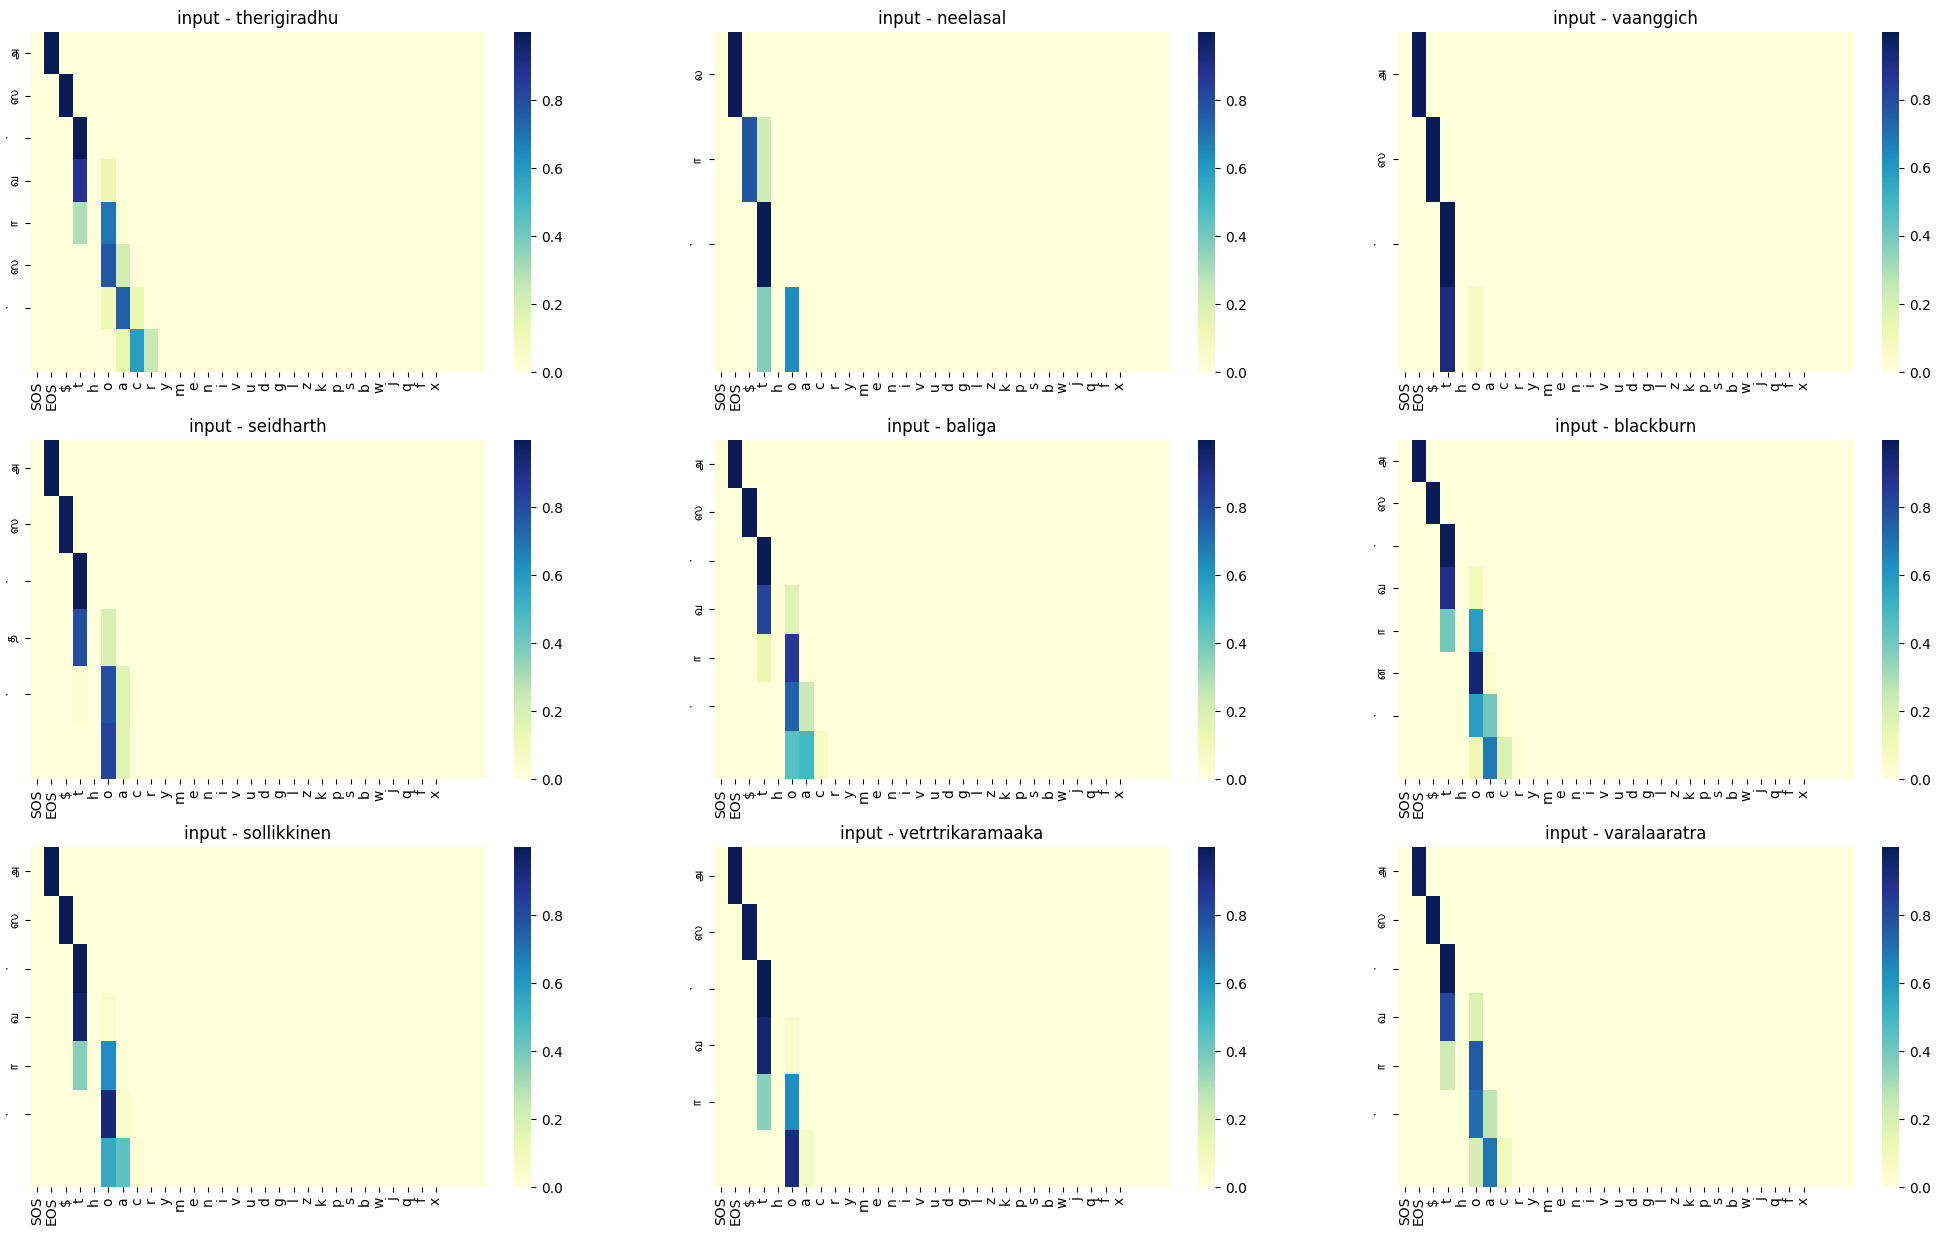

In [ ]:

fig, axes = plt.subplots(3, 3, figsize=(25, 15))

font_prop = FontProperties(fname='/content/Latha.ttf', size=7)
#ax = plt.subplot()
# for label in (axes.get_yticklabels()):
#     label.set_fontproperties(font_prop)

xlabels = [english.get_character(i) for i in range(0, english.n_chars)]

for i, ax in enumerate(axes.flatten()):
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop)
    ylabels = [letter for letter in out_words[i]]
    sns.heatmap(np.array(heatmaps[i]), ax=ax, cmap='YlGnBu', xticklabels = xlabels, yticklabels = ylabels)
    ax.set_title(f'input - {inputs[i]}')



In [ ]:
print(english.n_chars)

29
